# ウェルネス空調精度検証実行_4F西
## Import libraries

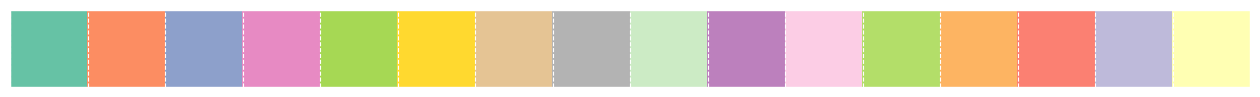

In [1]:
#from sl_canal_city_optimize.config import get_data_path, ACCESS_INFORMATION
from pathlib import Path
from sl_canal_city_optimize.predict_utils.score_utils import *
from sl_canal_city_optimize.predict_utils.data_preprocess import *
from sl_canal_city_optimize.predict_utils.models import XGBoostDiffModel
from sl_canal_city_optimize.predict_utils.plot_utils import *
from optuna.samplers import TPESampler
import optuna
import math
import jpholiday
import copy
from datetime import datetime, timedelta
from typing import Union, Literal
import plotly.express as px
import plotly.graph_objects as go
from prettytable import PrettyTable
from pylab import rcParams
from matplotlib import font_manager
import warnings
import seaborn.objects as so
import seaborn as sns
import random
from IPython.display import display, HTML
from pmdarima import arima
from pmdarima import utils
import pmdarima as pm
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.mode.chained_assignment = None


warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost')
# Filter out specific UserWarnings related to set_ticklabels
warnings.filterwarnings('ignore', category=UserWarning, module='plot_utils',
                        message='.*set_ticklabels.*should only be used with a fixed number of ticks.*')
# from logic import predict_cop,svr_predict,train_RA_8,train_TR_1,train_TR_2,train_TR_3
# graph setting
%matplotlib inline
sns.set_style("darkgrid", {'grid.linestyle': '--'})
sns.set_context("paper", 1.5, {"lines.linewidth": 1.5})
sns.set_palette("Set2")
current_palette = list(sns.color_palette(
    "Set2", n_colors=8) + sns.color_palette("Set3_r", n_colors=8))
sns.set_palette(current_palette)
sns.palplot(current_palette)

# 凡例の色を黒に設定
sns.set(rc={"legend.facecolor": "white",
            "legend.edgecolor": "#c7c5c7",
            "legend.labelcolor": "black"})

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic',
                               'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
rcParams['axes.axisbelow'] = True

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
path_name="G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/02_Codes/wellness_module"
sys.path.append(path_name)
from wellness_optimize.predict_utils.score_utils import *
from wellness_optimize.predict_utils.data_preprocess import *
from wellness_optimize.predict_utils.models import XGBoostDiffModel
from wellness_optimize.predict_utils.plot_utils import *

## データセットファイルを取得

### 初期設定

In [3]:
# Type new case name
CASE_NAME = "v.06.1.1"  # メインケース
#dataset_dir = "5_years_20240201.csv"
#unit = "(GJ)"
#OS: Literal["windows", "mac"] = "windows"

In [4]:
a="4F西"
display(a[0],a[2])

'4'

'西'

## Model Build & Train

- true: Cold_demand
- pred_diff: Cold_demand_diff_24
- y0_base: Cold_demand_shift_-24
- pred: pred_diff+y0_base

ウェルネス空調制御消費電力量予測

In [8]:
data_train=pd.read_csv("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/00_Data/01_PreProcessData/preprocessed_data_for_train.csv", encoding="cp932") # 前処理後のデータ
data_predict=pd.read_csv("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/00_Data/01_PreProcessData/preprocessed_data_for_predict.csv", encoding="cp932") # 前処理後のデータ

In [9]:
#object型となっているdatetimeとdateをdatetime型に変更
data_train["datetime"] = pd.to_datetime(data_train["datetime"])
data_train["date"] = pd.to_datetime(data_train["date"])
data_predict["datetime"] = pd.to_datetime(data_predict["datetime"])
data_predict["date"] = pd.to_datetime(data_predict["date"])

In [6]:
display(data_predict.columns)

Index(['空調電力予測_kWh', '空調負荷予測_kWh', '外気温度予測値_℃', '外気湿度予測値_RH',
       '室内機消費電力量_kWh_4F_西', '室内機消費電力量_kWh_4F_東', '室内機消費電力量_kWh_5F_西',
       '室内機消費電力量_kWh_5F_東', '室外機消費電力量_kWh_4F_西', '室外機消費電力量_kWh_4F_東',
       '室外機消費電力量_kWh_5F_西', '室外機消費電力量_kWh_5F_東', 'datetime', 'date',
       'fiscal_year', 'month', 'hour', 'is_holiday', '室内相対湿度_RH_4F',
       '室内相対湿度_RH_5F', '室内温度_C_4F執務室_西', '室内温度_C_4F執務室_東', '室内温度_C_5F執務室_西',
       '室内温度_C_5F執務室_東', '設定温度_C_4F執務室_西', '設定温度_C_4F執務室_東', '設定温度_C_5F執務室_西',
       '設定温度_C_5F執務室_東', '湿球温度_C', 'System_ON_OFF_4F_西', 'System_ON_OFF_4F_東',
       'System_ON_OFF_5F_西', 'System_ON_OFF_5F_東', '温度差(外気-室内)_C_4F_西',
       '温度差(外気-室内)_C_4F_東', '温度差(外気-室内)_C_5F_西', '温度差(外気-室内)_C_5F_東',
       '温度差(室内-設定)_C_4F_西', '温度差(室内-設定)_C_4F_東', '温度差(室内-設定)_C_5F_西',
       '温度差(室内-設定)_C_5F_東', '温度差(外気-設定)_C_4F_西', '温度差(外気-設定)_C_4F_東',
       '温度差(外気-設定)_C_5F_西', '温度差(外気-設定)_C_5F_東', 'Operation_Mode_4F_西',
       'Operation_Mode_4F_東', 'Operation_Mode_5F_西', 'Operation_Mode_5F

In [18]:
#predict用データの変更
for k in range(len(data_predict)):
    if data_predict.loc[k,"hour"]<=4 or data_predict.loc[k,"hour"]>=22:
        data_predict.at[k,"System_ON_OFF_4F_西"]=0
        data_predict.at[k,"System_ON_OFF_4F_東"]=0
        data_predict.at[k,"System_ON_OFF_5F_西"]=0
        data_predict.at[k,"System_ON_OFF_5F_東"]=0

In [19]:
a=data_predict[data_predict["hour"]<=4]
b=data_predict[data_predict["hour"]>=22]


In [21]:
display(a.loc[:,"System_ON_OFF_4F_西":].describe())
display(b.loc[:,"System_ON_OFF_4F_西":].describe())

,System_ON_OFF_4F_西,System_ON_OFF_4F_東,System_ON_OFF_5F_西,System_ON_OFF_5F_東,温度差(外気-室内)_C_4F_西,温度差(外気-室内)_C_4F_東,温度差(外気-室内)_C_5F_西,温度差(外気-室内)_C_5F_東,温度差(室内-設定)_C_4F_西,温度差(室内-設定)_C_4F_東,温度差(室内-設定)_C_5F_西,温度差(室内-設定)_C_5F_東,温度差(外気-設定)_C_4F_西,温度差(外気-設定)_C_4F_東,温度差(外気-設定)_C_5F_西,温度差(外気-設定)_C_5F_東,Operation_Mode_4F_西,Operation_Mode_4F_東,Operation_Mode_5F_西,Operation_Mode_5F_東
count,4757.0,4757.0,4757.0,4757.0,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000
mean,0.0,0.0,0.0,0.0,-10.039749,-9.997841,-9.889060,-9.884498,-0.001551,-0.001953,-0.001755,-0.001312,-10.041300,-9.999794,-9.890815,-9.885810,0.459323,0.459323,0.459323,0.459323
std,0.0,0.0,0.0,0.0,6.489909,6.492916,6.664998,6.564167,0.365922,0.366337,0.345967,0.344613,6.479494,6.482373,6.654554,6.554018,0.498395,0.498395,0.498395,0.498395
min,0.0,0.0,0.0,0.0,-26.875000,-25.625000,-25.000000,-25.000000,-24.500000,-24.500000,-23.000000,-23.000000,-26.875000,-25.625000,-25.000000,-25.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,-15.700000,-15.700000,-15.650000,-15.650000,0.000000,0.000000,0.000000,0.000000,-15.675000,-15.650000,-15.650000,-15.600000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,-10.150000,-10.150000,-9.950000,-10.050000,0.000000,0.000000,0.000000,0.000000,-10.150000,-10.150000,-9.950000,-10.050000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,-4.000000,-4.000000,-3.750000,-3.850000,0.000000,0.000000,0.000000,0.000000,-4.000000,-4.000000,-3.800000,-3.850000,1.000000,1.000000,1.000000,1.000000
max,0.0,0.0,0.0,0.0,11.600000,11.600000,11.600000,11.600000,0.985000,0.985000,0.985000,0.985000,2.345000,2.334375,2.300000,2.300000,1.000000,1.000000,1.000000,1.000000


,System_ON_OFF_4F_西,System_ON_OFF_4F_東,System_ON_OFF_5F_西,System_ON_OFF_5F_東,温度差(外気-室内)_C_4F_西,温度差(外気-室内)_C_4F_東,温度差(外気-室内)_C_5F_西,温度差(外気-室内)_C_5F_東,温度差(室内-設定)_C_4F_西,温度差(室内-設定)_C_4F_東,温度差(室内-設定)_C_5F_西,温度差(室内-設定)_C_5F_東,温度差(外気-設定)_C_4F_西,温度差(外気-設定)_C_4F_東,温度差(外気-設定)_C_5F_西,温度差(外気-設定)_C_5F_東,Operation_Mode_4F_西,Operation_Mode_4F_東,Operation_Mode_5F_西,Operation_Mode_5F_東
count,1900.0,1900.0,1900.0,1900.0,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,0.0,0.0,0.0,0.0,-9.068348,-9.024034,-8.876502,-8.943862,0.142003,0.139064,0.083199,0.155048,-8.926346,-8.884970,-8.793303,-8.788813,0.462105,0.462105,0.462105,0.462105
std,0.0,0.0,0.0,0.0,6.223540,6.236291,6.496439,6.314184,0.626636,0.629362,0.498504,0.557787,6.347011,6.352819,6.535804,6.433341,0.498693,0.498693,0.498693,0.498693
min,0.0,0.0,0.0,0.0,-23.950000,-23.950000,-23.950000,-23.950000,-4.915000,-4.915000,-2.000000,-1.000000,-23.950000,-23.950000,-23.950000,-23.950000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,-14.350000,-14.350000,-14.450000,-14.400000,0.000000,0.000000,0.000000,0.000000,-14.281250,-14.273750,-14.350000,-14.300000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,-8.912500,-8.900000,-8.800000,-8.900000,0.000000,0.000000,0.000000,0.000000,-8.900000,-8.900000,-8.750000,-8.800000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,-3.450000,-3.450000,-3.050000,-3.237500,0.000000,0.000000,0.000000,0.000000,-3.200000,-3.200000,-2.987500,-3.000000,1.000000,1.000000,1.000000,1.000000
max,0.0,0.0,0.0,0.0,2.700000,3.200000,3.325000,2.950000,2.675000,2.550000,2.000000,2.000000,3.100000,3.200000,3.325000,3.100000,1.000000,1.000000,1.000000,1.000000


In [24]:
data_predict.to_csv("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/00_Data/01_PreProcessData/preprocessed_data_for_predict.csv",encoding="cp932", index=False)

In [6]:
dict_column_name=pd.read_excel("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/00_Data/03_MasterInfo/preprocessed_column_name.xlsx", sheet_name=None)
dict_column_name_experiment=pd.read_excel("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/00_Data/03_MasterInfo/説明変数.xlsx", sheet_name=None,index_col="除くカラム")

In [4]:
master_data=pd.read_excel("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/00_Data/03_MasterInfo/マスタデータ.xlsx", sheet_name=None)

In [11]:
a=master_data["予測モデル(その他)"].loc[:,"4F西"].tolist()
l_in = [s for s in a if '室内温度' in s]
display(l_in)

['室内温度_C_4F執務室_西']

In [12]:
df = data_predict[(data_predict['date'] >= '2023-05-01') & (data_predict['date'] <= '2023-07-31')]
df = df.iloc[-24:,:] # 最新24時間分のデータを取得
df = df.reset_index(drop=True)
display(df.loc[0:10,l_in])

,室内温度_C_4F執務室_西
0,26.00
1,26.00
2,26.00
3,26.00
4,26.00
5,26.00
6,26.00
7,26.55
8,26.50
9,25.00


In [10]:
display(master_data["予測モデル(説明変数)"].loc[:,"4F西"].tolist())
display(master_data["予測モデル(その他)"].loc[:,"4F西"].tolist())

['外気温度予測値_℃',
 '外気湿度予測値_RH',
 'fiscal_year',
 'month',
 'hour',
 'is_holiday',
 '設定温度_C_4F執務室_西',
 '湿球温度_C',
 'System_ON_OFF_4F_西',
 '温度差(室内-設定)_C_4F_西',
 '温度差(外気-設定)_C_4F_西',
 'Operation_Mode_4F_西',
 'DayType_土',
 'DayType_日',
 'DayType_月',
 'DayType_木',
 'DayType_水',
 'DayType_火',
 'DayType_金']

['室内機消費電力量_kWh_4F_西',
 '室外機消費電力量_kWh_4F_西',
 'datetime',
 'date',
 '室内温度_C_4F執務室_西',
 '空調電力予測_kWh',
 '空調負荷予測_kWh',
 '設定温度_C_4F執務室_西',
 '室内相対湿度_RH_4F']

In [13]:
df = data_predict[(data_predict['date'] >= '2023-05-01') & (data_predict['date'] <= '2023-07-31')]
df = df.iloc[-24:,:] # 最新24時間分のデータを取得
df = df.reset_index(drop=True)


In [13]:
display(df["date"][0].date().month)

7

In [18]:
display(master_data["最適化"])
display(master_data["最適化"].iloc[0,:])

,月,期間区分,重み係数,Unnamed: 3,Unnamed: 4,Unnamed: 5,知的生産性,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,快適性指数,Unnamed: 16,Unnamed: 17,Unnamed: 18,ウェルネス指数重み係数,Unnamed: 20,設定温度範囲,Unnamed: 22,ベンチマークケース設定温度
0,NaN,NaN,ウェルネス重み係数_コアタイム,省エネ重み係数_コアタイム,ウェルネス重み係数_残業時,省エネ重み係数_残業時,知的生産性_朝_A,知的生産性_朝_B,知的生産性_朝_C,知的生産性_昼_A,...,知的生産性_夕_C,室内相対湿度 [%],代謝量 [met],着衣量 [clo],気流速度 [m/s],知的生産性,快適性指数,上限値,下限値,NaN
1,1.0,暖房期,0.5,0.5,0.5,0.5,-0.343,15.088,-165.5,0,...,-15.312,40,1.1,1,0.1,0.75,0.25,28,20,26.0
2,2.0,暖房期,0.5,0.5,0.5,0.5,-0.343,15.088,-165.5,0,...,-15.312,40,1.1,1,0.1,0.75,0.25,28,20,26.0
3,3.0,暖房期,0.5,0.5,0.5,0.5,-0.343,15.088,-165.5,0,...,-15.312,40,1.1,1,0.1,0.75,0.25,28,20,26.0
4,4.0,中間期,0.5,0.5,0.5,0.5,0,0,0,0,...,0,50,1.1,0.8,0.1,0.75,0.25,28,20,26.0
5,5.0,中間期,0.5,0.5,0.5,0.5,0,0,0,0,...,0,50,1.1,0.8,0.1,0.75,0.25,28,20,26.0
6,6.0,冷房期,0.5,0.5,0.5,0.5,-0.213,10.924,-139.918,0,...,0,60,1.1,0.6,0.1,0.75,0.25,28,20,26.0
7,7.0,冷房期,0.5,0.5,0.5,0.5,-0.213,10.924,-139.918,0,...,0,60,1.1,0.6,0.1,0.75,0.25,28,20,26.0
8,8.0,冷房期,0.5,0.5,0.5,0.5,-0.213,10.924,-139.918,0,...,0,60,1.1,0.6,0.1,0.75,0.25,28,20,26.0
9,9.0,冷房期,0.5,0.5,0.5,0.5,-0.213,10.924,-139.918,0,...,0,60,1.1,0.6,0.1,0.75,0.25,28,20,26.0


月                            NaN
期間区分                         NaN
重み係数             ウェルネス重み係数_コアタイム
Unnamed: 3         省エネ重み係数_コアタイム
Unnamed: 4         ウェルネス重み係数_残業時
Unnamed: 5           省エネ重み係数_残業時
知的生産性                  知的生産性_朝_A
Unnamed: 7             知的生産性_朝_B
Unnamed: 8             知的生産性_朝_C
Unnamed: 9             知的生産性_昼_A
Unnamed: 10            知的生産性_昼_B
Unnamed: 11            知的生産性_昼_C
Unnamed: 12            知的生産性_夕_A
Unnamed: 13            知的生産性_夕_B
Unnamed: 14            知的生産性_夕_C
快適性指数                室内相対湿度 [%] 
Unnamed: 16            代謝量 [met]
Unnamed: 17            着衣量 [clo]
Unnamed: 18           気流速度 [m/s]
ウェルネス指数重み係数                知的生産性
Unnamed: 20                快適性指数
設定温度範囲                       上限値
Unnamed: 22                  下限値
ベンチマークケース設定温度                NaN
Name: 0, dtype: object

In [6]:
#月別に必要なマスタデータを抽出する関数
def extract_master_data(df,master_data):
    a=master_data.iloc[0:1,:]
    b=master_data[master_data["月"]==df["date"][0].date().month]
    master_data_month=pd.concat([a,b],axis=0,ignore_index=True)
    #display(master_data_month)
    columns_list=master_data_month.columns
    master_data_month['月'] = master_data_month['月'].astype('object') 
    master_data_month.at[0, '月'] = columns_list[0]
    master_data_month.at[0, '期間区分'] = columns_list[1]
    master_data_month['ベンチマークケース設定温度'] = master_data_month['ベンチマークケース設定温度'].astype('object') 
    master_data_month.at[0, 'ベンチマークケース設定温度'] = columns_list[-1]
    #display(columns_list[-1])
    master_data_month.columns=master_data_month.iloc[0]
    master_data_month=master_data_month.drop(master_data_month.index[0])
    master_data_month.reset_index(drop=True,inplace=True)
    display(master_data_month)
    return master_data_month

In [14]:
extracted_master_data=extract_master_data(df,master_data["最適化"])
display(extract_master_data(df,master_data["最適化"]))
display(extracted_master_data.loc[0,"期間区分"])

,月,期間区分,ウェルネス重み係数_コアタイム,省エネ重み係数_コアタイム,ウェルネス重み係数_残業時,省エネ重み係数_残業時,知的生産性_朝_A,知的生産性_朝_B,知的生産性_朝_C,知的生産性_昼_A,...,知的生産性_夕_C,室内相対湿度 [%],代謝量 [met],着衣量 [clo],気流速度 [m/s],知的生産性,快適性指数,上限値,下限値,ベンチマークケース設定温度
0,7.0,冷房期,0.5,0.5,0.5,0.5,-0.213,10.924,-139.918,0,...,0,60,1.1,0.6,0.1,0.75,0.25,28,20,26.0


,月,期間区分,ウェルネス重み係数_コアタイム,省エネ重み係数_コアタイム,ウェルネス重み係数_残業時,省エネ重み係数_残業時,知的生産性_朝_A,知的生産性_朝_B,知的生産性_朝_C,知的生産性_昼_A,...,知的生産性_夕_C,室内相対湿度 [%],代謝量 [met],着衣量 [clo],気流速度 [m/s],知的生産性,快適性指数,上限値,下限値,ベンチマークケース設定温度
0,7.0,冷房期,0.5,0.5,0.5,0.5,-0.213,10.924,-139.918,0,...,0,60,1.1,0.6,0.1,0.75,0.25,28,20,26.0


,月,期間区分,ウェルネス重み係数_コアタイム,省エネ重み係数_コアタイム,ウェルネス重み係数_残業時,省エネ重み係数_残業時,知的生産性_朝_A,知的生産性_朝_B,知的生産性_朝_C,知的生産性_昼_A,...,知的生産性_夕_C,室内相対湿度 [%],代謝量 [met],着衣量 [clo],気流速度 [m/s],知的生産性,快適性指数,上限値,下限値,ベンチマークケース設定温度
0,7.0,冷房期,0.5,0.5,0.5,0.5,-0.213,10.924,-139.918,0,...,0,60,1.1,0.6,0.1,0.75,0.25,28,20,26.0


'冷房期'

In [16]:
display(extracted_master_data.iloc[0,15:19])
a=extracted_master_data.iloc[0:1,15:19]
display(a.iloc[0,0])
display(extracted_master_data.iloc[0:1,2:6].columns)

0
室内相対湿度 [%]      60
代謝量 [met]      1.1
着衣量 [clo]      0.6
気流速度 [m/s]     0.1
Name: 0, dtype: object

60

Index(['ウェルネス重み係数_コアタイム', '省エネ重み係数_コアタイム', 'ウェルネス重み係数_残業時', '省エネ重み係数_残業時'], dtype='object', name=0)

In [30]:
split_index=random.sample(range(len(data_train)), k=int(len(data_train)*0.7))
display(type(split_index))
a=data_train.loc[split_index]
display(data_train.index[split_index].tolist())
display(data_train.loc[data_train.index[split_index].tolist(),:].loc[:,"datetime"])
#display(data_train[data_train.index[data_train.index.isin(split_index)]].loc[:,"datetime"].tolist())
#display(a)
#display(a.reset_index(drop=True))
#display(a)
#display(data_train.loc[split_index,"datetime"].tolist())

list

[17515,
 16013,
 14079,
 16242,
 1164,
 2082,
 18500,
 12138,
 16496,
 15468,
 13409,
 21099,
 11484,
 19121,
 13814,
 5833,
 3814,
 21230,
 19887,
 1962,
 8727,
 13867,
 12800,
 14776,
 10247,
 20322,
 6288,
 4979,
 14203,
 22380,
 22385,
 6705,
 5335,
 12755,
 19660,
 12480,
 3227,
 18873,
 18374,
 11473,
 3243,
 9722,
 2914,
 5330,
 20265,
 15182,
 17176,
 13621,
 16525,
 6829,
 19116,
 9900,
 8371,
 9756,
 13481,
 10267,
 8212,
 14182,
 3893,
 18820,
 3643,
 7386,
 13619,
 6264,
 9783,
 4206,
 1691,
 22733,
 5742,
 18028,
 3743,
 10957,
 13289,
 13741,
 657,
 4893,
 17710,
 9583,
 1951,
 9009,
 21261,
 3213,
 21108,
 17577,
 20021,
 15749,
 9305,
 7789,
 14180,
 11110,
 15262,
 20625,
 10158,
 11215,
 21805,
 4321,
 1116,
 13935,
 9070,
 14175,
 22468,
 6479,
 9621,
 8447,
 6274,
 7039,
 18091,
 17816,
 22453,
 21036,
 22627,
 16160,
 17973,
 3728,
 21116,
 14088,
 10136,
 1120,
 4655,
 4369,
 15124,
 16158,
 16897,
 8318,
 20260,
 6083,
 19636,
 5883,
 16283,
 3204,
 4921,
 3722,


17515   2023-08-24 20:00:00
16013   2023-06-23 06:00:00
14079   2023-04-02 10:00:00
16242   2023-07-02 19:00:00
1164    2021-05-19 21:00:00
                ...        
9117    2022-09-07 16:00:00
7306    2022-02-07 02:00:00
13192   2023-02-24 11:00:00
20860   2024-01-11 05:00:00
469     2021-04-20 13:00:00
Name: datetime, Length: 15959, dtype: datetime64[ns]

In [17]:
#調べたい系統を検索
#ここのパラメータをいじって精度検証
floor=4
direction="西"
floor_direction_name=str(floor)+"F"+direction
eval_metric="rmse"
x=23#何番目の組み合わせ(どのカラムを抜くか)を設定 元：23
column_name=dict_column_name[floor_direction_name]#系統別で用いられる説明変数と目的変数のカラム名

In [18]:
#精度検証のための表を取得
df_column_name=dict_column_name_experiment[floor_direction_name]
used_column_list=[]#精度検証で選ばれた説明変数に使うカラム名
delete_column=[]#目的変数用のカラム名と不要なカラム名
#df_column_name.iloc[〇,k]の○に設定(どのカラムを抜くか)を決定
for k in range(len(df_column_name.columns)):
    if df_column_name.iloc[x,k]==1:
        used_column_list.append(df_column_name.columns.tolist()[k])
    else :
        if df_column_name.iloc[x,k]==2:
            delete_column.append(df_column_name.columns.tolist()[k])
display(used_column_list)

['外気温度予測値_℃',
 '外気湿度予測値_RH',
 'fiscal_year',
 'month',
 'hour',
 'is_holiday',
 '設定温度_C_4F執務室_西',
 '湿球温度_C',
 'System_ON_OFF_4F_西',
 '温度差(室内-設定)_C_4F_西',
 '温度差(外気-設定)_C_4F_西',
 'Operation_Mode_4F_西',
 'DayType_土',
 'DayType_日',
 'DayType_月',
 'DayType_木',
 'DayType_水',
 'DayType_火',
 'DayType_金']

精度検証用  
学習期間2022年4月～2023年3月  
テスト期間2023年4月～2024年3月

In [20]:
#精度検証
#prepared_data：前処理したデータ
#prepared_dataは学習データのみに適用する場合
##曜日のダミー変数化
data_train=pd.get_dummies(data_train,dtype=int)
data_predict=pd.get_dummies(data_predict,dtype=int)
##
data_train=data_train[column_name["前処理データ名"].tolist()]#検証する系統のデータを抽出
    ###精度検証用
    #学習期間2021年4月～2023年3月
    #テスト期間2023年4月～2024年3月

##ランダム##
split_index=random.sample(range(len(data_train)), k=int(len(data_train)*0.7))
prepared_data_train=data_train.loc[split_index,:]
##
#prepared_data_train=data_train[data_train["date"]<"2023-04-01"]#学習データ
#2021年～2022年のデータを用いる
#prepared_data_train=data_train[data_train["date"]<"2022-04-01"]#学習データ
#

    #外れ値の除去
a=prepared_data_train["室内温度_C_{}F執務室_{}".format(floor,direction)].describe().tolist()[1]+2*prepared_data_train["室内温度_C_{}F執務室_{}".format(floor,direction)].describe().tolist()[2]
b=prepared_data_train["室内温度_C_{}F執務室_{}".format(floor,direction)].describe().tolist()[1]-2*prepared_data_train["室内温度_C_{}F執務室_{}".format(floor,direction)].describe().tolist()[2]
prepared_data_train=prepared_data_train[prepared_data_train["室内温度_C_{}F執務室_{}".format(floor,direction)]<=a]
prepared_data_train=prepared_data_train[prepared_data_train["室内温度_C_{}F執務室_{}".format(floor,direction)]>=b]
    #空調負荷
a=prepared_data_train["空調電力予測_kWh"].copy()
b=a.describe().tolist()[1]+2*a.describe().tolist()[2]
prepared_data_train=prepared_data_train[prepared_data_train["空調電力予測_kWh"]<=b]
prepared_data_train_a=prepared_data_train[(prepared_data_train["hour"]>=8) & (prepared_data_train["hour"]<=18)]#コアタイム(8~18)のみ抽出
a=prepared_data_train_a["空調負荷予測_kWh"].copy()
b=a.describe().tolist()[1]+2*a.describe().tolist()[2]
prepared_data_train_a=prepared_data_train_a[prepared_data_train_a["空調負荷予測_kWh"]<=b]    
max_air_load=prepared_data_train_a["空調負荷予測_kWh"].max()#最大負荷値算出
prepared_data_train=prepared_data_train[prepared_data_train["空調負荷予測_kWh"]<=max_air_load]
    ##
    #部分負荷率のレコードの発生頻度と外れ値として除外すべきかの検討
    #本来は4F西以外の系統も削除しなければならない
#prepared_data_train=prepared_data_train.reset_index(drop=True)
#c=[]
#for k in range(len(prepared_data_train)):
#    if ~((prepared_data_train.loc[k,"System_ON_OFF_4F_西"]==1) and ((prepared_data_train.loc[k,"室内機消費電力量_kWh_4F_西"]>1)or(prepared_data_train.loc[k,"室外機消費電力量_kWh_4F_西"]>1))):
#        c.append(k)
#prepared_data_train=prepared_data_train.loc[c,:]

##ランダム##
test_index=data_predict.index.tolist()
test_index=list(set(test_index)-set(split_index))
prepared_data_test=data_predict.loc[test_index,:]
display(len(test_index))
display(len(test_index)+len(split_index))
display(len(data_predict))
##
##2021年～2022年のデータを用いる
#prepared_data_test=data_predict[data_predict["date"]<"2023-04-01"]#テストデータ
#prepared_data_test=prepared_data_test[prepared_data_test["date"]>="2022-04-01"]#テストデータ
##
##もともと
#prepared_data_test=data_predict[data_predict["date"]>="2023-04-01"]#テストデータ
##

datetime_data=prepared_data_test[delete_column[2]].tolist()
date_data=prepared_data_test[delete_column[3]].tolist()
objective_data_train=prepared_data_train[delete_column[0]]+prepared_data_train[delete_column[1]].tolist() # 学習データの目的変数
objective_data_test=prepared_data_test[delete_column[0]]+prepared_data_test[delete_column[1]].tolist() # テストデータの目的変数
prepared_data_train=prepared_data_train[prepared_data_train.columns[prepared_data_train.columns.isin(used_column_list)]] # 学習データの説明変数
prepared_data_test=prepared_data_test[prepared_data_test.columns[prepared_data_test.columns.isin(used_column_list)]] # テストデータの説明変数
prepared_data_train["総消費電力量"]=objective_data_train
prepared_data_test["総消費電力量"]=objective_data_test

6840

22799

22799

精度検証用  
学習期間2021年4月～2022年3月，2023年4月～2024年3月  
テスト期間2022年4月～2023年3月

## `BEFORE` Hyperparameter Tuning (ハイパーパラメータチューニングの`前`)

In [21]:
def plot_scatter_formatted(score_evaluator_val, ticks, feature_name):
    fig = plt.figure(figsize=(6, 10))
    ax2 = fig.add_subplot(1, 1, 1)
    xticks = ticks
    plot_scatter(
        ax2,
        score_evaluator_val.df,
        x="true",
        y="pred",
        xlabel="実績値",
        ylabel="予測値",
        xticks=xticks,
        alpha=0.5,
        title="val",
        color="tab:blue",
    )
    ax2.set_xlabel(f"実績値")
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks, fontsize=16)
    ax2.set_ylabel(f"予測値")
    ax2.set_yticks(xticks)
    ax2.set_yticklabels(xticks, fontsize=16)
    ax2.set_title(f"{feature_name} ", fontsize=18)
    fig.tight_layout()


In [22]:
# モデルの学習
input_features=used_column_list
output_features="総消費電力量"
model = XGBoostDiffModel(input_features, output_features)
X_train, y_train_diff, X_val, y_val_diff = model.preprocess(prepared_data_train, prepared_data_test)
model.train(X_train, y_train_diff)
#display(y_train_diff.values)

# モデルの予測
#y_train_y0_base = train["Cold_demand_shift_-24"].values
#y_val_y0_base = valid["Cold_demand_shift_-24"].values
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

#y_train = train["Cold_demand"].values
#y_val = valid["Cold_demand"].values

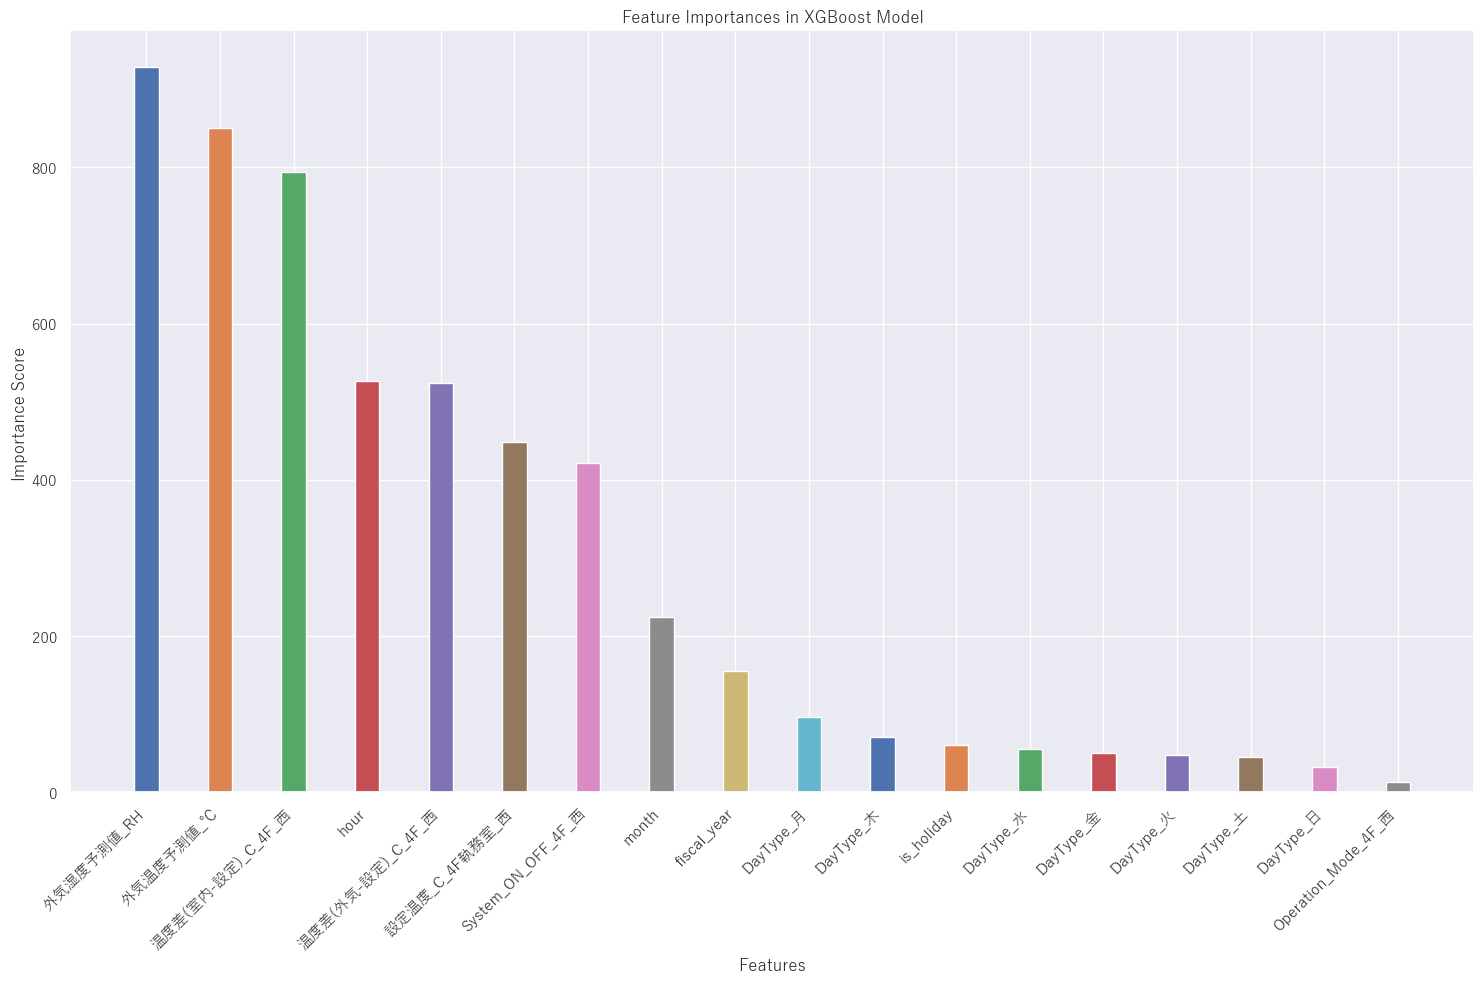

In [23]:
# 　特徴量の重要度をプロット
plot_feature_importance(model)

==train==
MAE = 0.40965637486907236
RMSE = 0.5511193346350455
MAPE(%) --eps=0.001 --exclude_under=None = 13455.541611336042
MAPE(%) --eps=0 --exclude_under=2 = 20.590719810711487
==valid==
MAE = 0.7681299549725193
RMSE = 1.390169469798917
MAPE(%) --eps=0.001 --exclude_under=None = 22803.457348239113
MAPE(%) --eps=0 --exclude_under=2 = 50.39295018941024


G:\共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/02_Codes/wellness_module\wellness_optimize\predict_utils\score_utils.py:73: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.df["pct(true-pred)"].iloc[use_i

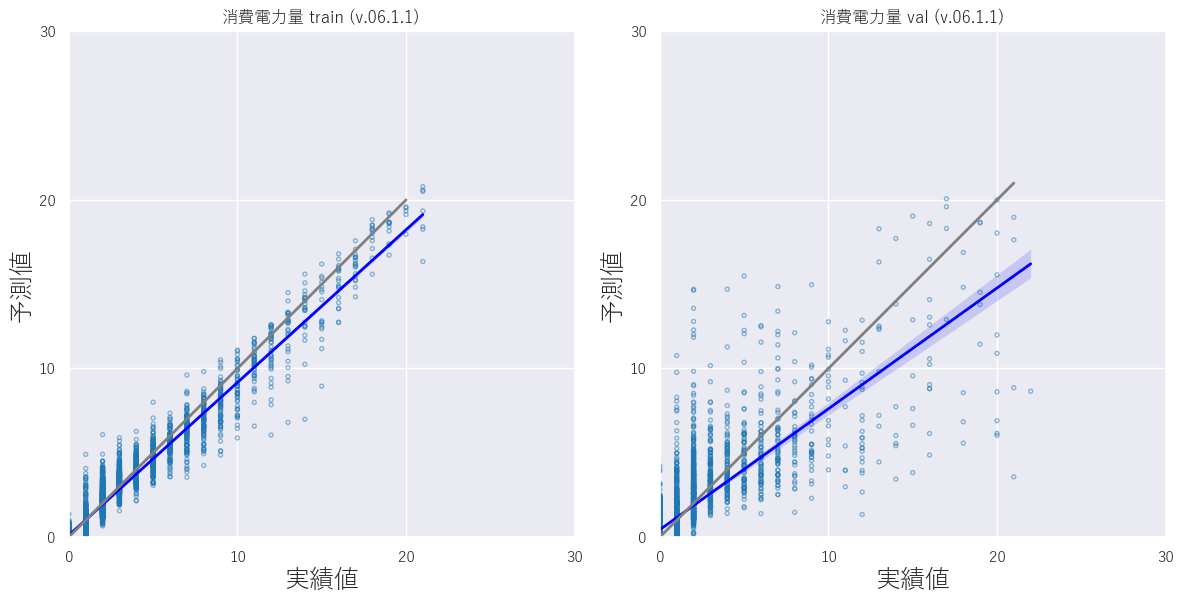

In [24]:
X_train = pd.DataFrame(X_train, columns=input_features)
X_val = pd.DataFrame(X_val, columns=input_features)
# 予測結果の評価
print("==train==")
score_evaluator_train = ScoreEvaluator(X_train, y_train_diff, pred_train)
score_evaluator_train.evaluate()

print("==valid==")
score_evaluator_val = ScoreEvaluator(X_val, y_val_diff, pred_val)
score_evaluator_val.evaluate()

ticks=np.arange(0, 31, 10)

feature_name = "消費電力量"
plot_scatters_train_valid(score_evaluator_train,
                         score_evaluator_val, ticks, CASE_NAME, feature_name)

メモ  
元：MAE=0.811 RMSE=1.675  
ランダム：MAE=0.5447 RMSE=0.929  
2023年除去：MAE=0.829 RMSE=1.623  
低負荷レコード： MAE=0.927 RMSE=2.418

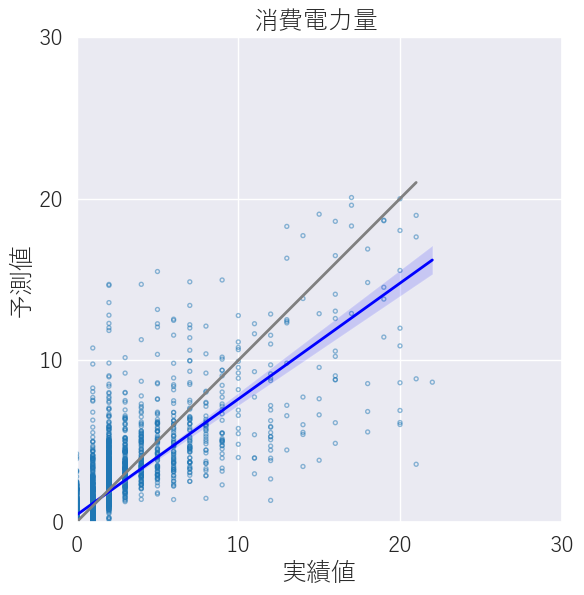

In [25]:
unit = "(GJ)"
plot_scatter_formatted(score_evaluator_val, ticks,
                       feature_name)

## Hyperparameter Tuning (ハイパーパラメータチューニングの`実装`)

#### ハイパーパラメータチューニングを`実行`する時にコメントを解除する

In [26]:
study_name="wellness_study"
sampler = TPESampler(seed=123)
storage_url = "sqlite:///wellness_study.db" # フォルダを作成する必要

In [27]:
def objective(
    trial,
    train,
    valid,
    input_features,
    output_features,
    params,
    model_name,
):
    """Objective function for Optuna hyperparameter tuning."""
    # Define the hyperparameters to tune
    params = params.copy()
    # CatBoost hyperparameters
    # "depth": trial.suggest_int("depth", 3, 10),
    # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    # "iterations": trial.suggest_int("iterations", 100, 1000),
    # "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
    #### XGBoost hyperparameters ####

    # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    # "max_depth": trial.suggest_int("max_depth", 3, 10),
    # "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
    # "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    # "gamma": trial.suggest_float("gamma", 0.0, 1.0),
    # "subsample": trial.suggest_float("subsample", 0.5, 1.0),
    # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    # "num_round": trial.suggest_int("num_round", 100, 1000),

    if model_name == "xgboost":
        model_tuned = XGBoostDiffModel(input_features, output_features, params)

    elif model_name == "catboost":
        model_tuned = CatBoostDiffModel(input_features, output_features, params)
    elif model_name == "lightgbm":
        model_tuned = LightGBMDiffModel(input_features, output_features, params)
    elif model_name == "XGboost":
        model_tuned = xgb.train(
        params = params,
        dtrain = train,
        evals = [(train, "train"), (valid, "valid")],
        num_boost_round = 50
    )

    X_train, y_train_diff, X_val, y_val_diff = model_tuned.preprocess(train, valid)
    eval_set = [((X_val, y_val_diff))]  # Example, adjust to your data

    # model_tuned.train(
    #     X_train, y_train_diff, eval_set=eval_set, early_stopping_rounds=10
    # )
    model_tuned.train(X_train, y_train_diff)

    pred_train = model_tuned.predict(X_train)
    pred_val = model_tuned.predict(X_val)


    # Evaluate the model_tuned
    try:
        score_evaluator_val = ScoreEvaluator(X_val, y_val_diff, pred_val)
        val_score = score_evaluator_val.evaluate(is_print=False)
        print(f"Trial {trial.number}, Val score: {val_score}")
        if val_score is None or not isinstance(val_score, (int, float)):
            raise ValueError("Invalid evaluation score")

    except Exception as e:
        print(f"Trial failed due to an error: {e}")
        return float("inf")  # Return a default bad score

    return val_score

In [ ]:
# studyを作成
study = optuna.create_study(
    study_name=study_name,
    storage=storage_url,
    direction="minimize",  # or "maximize", depending on your objective
    load_if_exists=True  # If the study already exists, it will be loaded instead of creating a new one
)
study.optimize(lambda trial: objective(trial, prepared_data_train, prepared_data_test, input_features, output_features,
        params={
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),

        # "alpha": trial.suggest_float("alpha", 0.0, 1.0),
        # "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        # "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        # "num_round": trial.suggest_int("num_round", 100, 1000),
    },
        model_name="xgboost"), n_trials=50)

In [29]:
# 指定されたOptunaストレージに保存されているすべてのスタディの概要を印刷します。
print_study_summaries(storage_url)

スタディ名: wellness_study
  試行回数: 2050
  ベストトライアル番号: 1470
  ベスト値(MAE): 0.4041715664680135
  ベストパラメータ: {'learning_rate': 0.09203532771972003, 'max_depth': 9, 'max_delta_step': 8, 'min_child_weight': 1, 'n_estimators': 698}
----------


In [30]:
# 最良のスタディの情報を出力します
best_study_params = find_best_study(storage_url)

ベストスタディ名: wellness_study
ベストトライアル番号: 1470
ベスト値(MAE): 0.4041715664680135
ベストハイパーパラメータ: {'learning_rate': 0.09203532771972003, 'max_depth': 9, 'max_delta_step': 8, 'min_child_weight': 1, 'n_estimators': 698}


In [31]:
# 最高のパラメータを使って再学習 (CASE_NAMEによってハイパーパラメータを変更する), best_paramsはbest_study_paramsから取得するか、手動で設定する
best_params = best_study_params
# best_params = {'learning_rate': 0.07583250304738903, 'max_depth': 7,
#                'max_delta_step': 5, 'min_child_weight': 6, 'n_estimators': 721
#               }
model = XGBoostDiffModel(input_features, output_features, params=best_params)
X_train, y_train_diff, X_val, y_val_diff = model.preprocess(prepared_data_train, prepared_data_test)
model.train(X_train, y_train_diff)

# モデルの予測
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


In [34]:
display(X_val)

,外気温度予測値_℃,外気湿度予測値_RH,fiscal_year,month,hour,is_holiday,設定温度_C_4F執務室_西,湿球温度_C,System_ON_OFF_4F_西,温度差(室内-設定)_C_4F_西,温度差(外気-設定)_C_4F_西,Operation_Mode_4F_西,DayType_土,DayType_日,DayType_月,DayType_木,DayType_水,DayType_火,DayType_金
4,9.75,80.30,2021,4,4,0,24.500,9.445312,0,0.000,-14.750,0,0,0,0,1,0,0,0
6,9.70,79.05,2021,4,6,0,24.500,9.396875,1,0.000,-14.800,0,0,0,0,1,0,0,0
8,12.10,76.25,2021,4,8,0,23.000,11.721875,0,0.025,-10.900,0,0,0,0,1,0,0,0
9,14.65,71.50,2021,4,9,0,23.000,14.192187,0,0.000,-8.350,0,0,0,0,1,0,0,0
11,18.40,59.50,2021,4,11,0,23.000,18.112500,0,0.000,-4.600,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22790,22.65,48.15,2023,3,15,1,22.500,22.296094,0,-1.165,0.150,1,0,1,0,0,0,0,0
22791,22.20,50.40,2023,3,16,1,23.035,21.853125,0,-0.535,-0.835,1,0,1,0,0,0,0,0
22794,17.55,79.55,2023,3,19,1,23.500,17.275781,0,0.000,-5.950,1,0,1,0,0,0,0,0
22795,16.50,82.70,2023,3,20,1,20.465,16.242188,0,3.035,-3.965,1,0,1,0,0,0,0,0


In [ ]:
X_val_ex=X_val.iloc[-2:-1]
print("元の設定温度({}℃)の時の予測結果".format(X_val.iloc[-1,6]))
display(model.predict(X_val_ex))
for k in range(20):
    X_val_ex["設定温度_C_4F執務室_西"]=20+k*0.5
    #display(X_val_ex.loc[:,"設定温度_C_4F執務室_西"])
    print("設定温度が{}℃の時の予測結果".format(20+k*0.5))
    display(model.predict(X_val_ex))


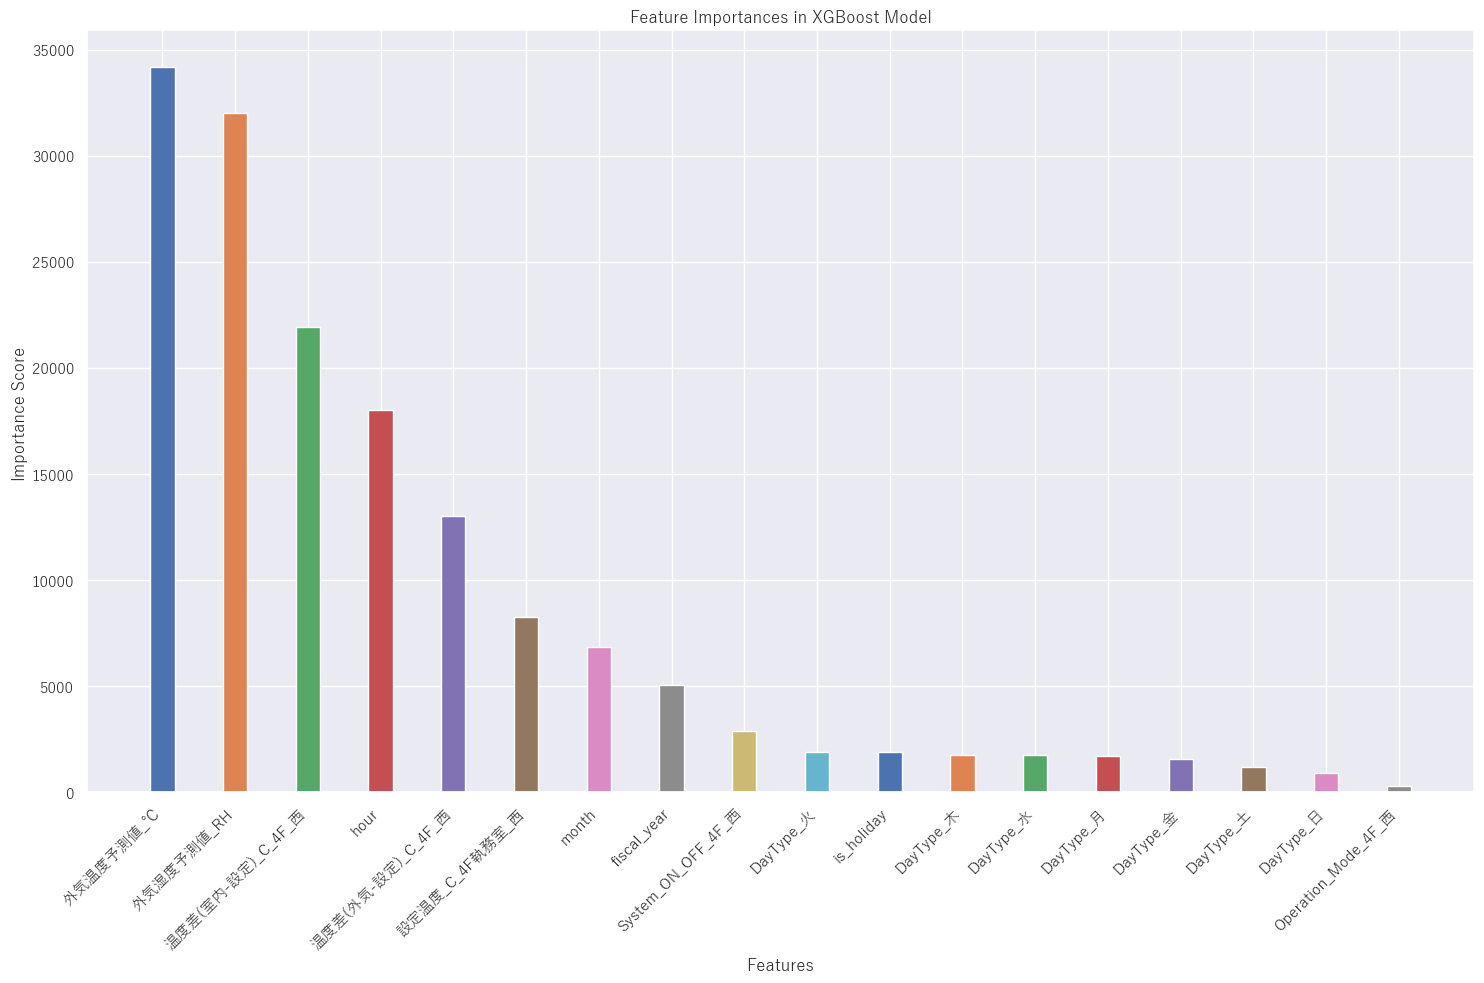

In [32]:
# 　特徴量の重要度をプロット
plot_feature_importance(model)

==train==
MAE = 0.07225605787998582
RMSE = 0.10030824619611466
MAPE(%) --eps=0.001 --exclude_under=None = 2802.9509466835707
MAPE(%) --eps=0 --exclude_under=2 = 2.541043642095809
==valid==
MAE = 0.7086536173496234
RMSE = 1.2989606631237889
MAPE(%) --eps=0.001 --exclude_under=None = 19548.400783374
MAPE(%) --eps=0 --exclude_under=2 = 46.98672133119734


G:\共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/wellness_optimize/02_Codes/wellness_module\wellness_optimize\predict_utils\score_utils.py:73: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.df["pct(true-pred)"].iloc[use_i

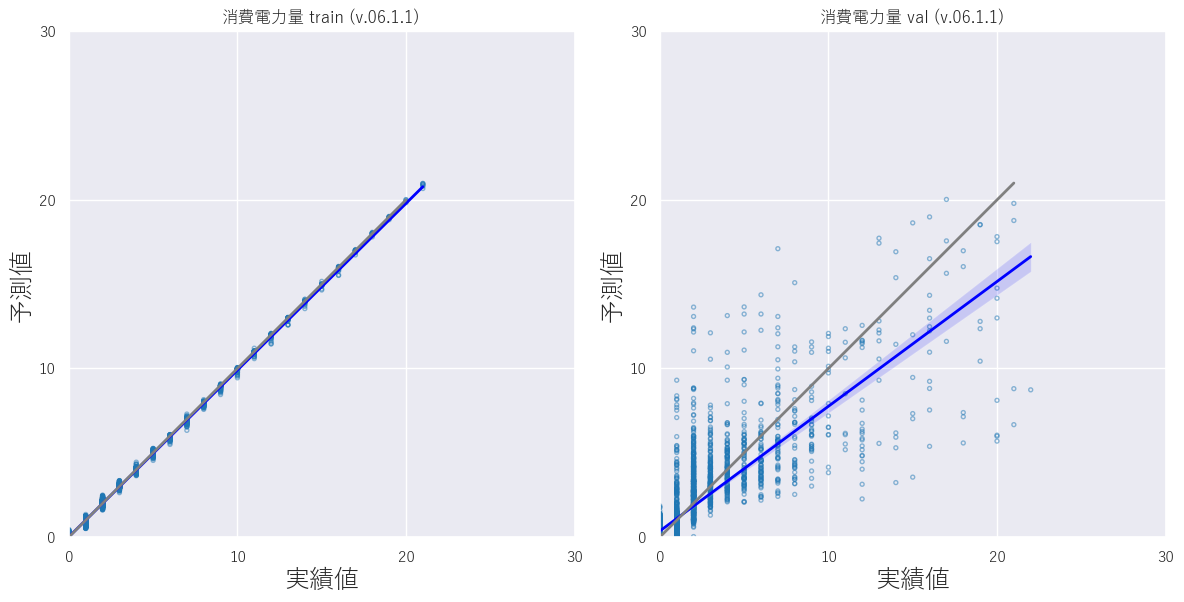

In [33]:
X_train = pd.DataFrame(X_train, columns=input_features)
X_val = pd.DataFrame(X_val, columns=input_features)
# 予測結果の評価
print("==train==")
score_evaluator_train = ScoreEvaluator(X_train, y_train_diff, pred_train)
score_evaluator_train.evaluate()

print("==valid==")
score_evaluator_val = ScoreEvaluator(X_val, y_val_diff, pred_val)
score_evaluator_val.evaluate()

ticks=np.arange(0, 31, 10)

feature_name = "消費電力量"
plot_scatters_train_valid(score_evaluator_train,
                         score_evaluator_val, ticks, CASE_NAME, feature_name)

## Plot Results (グラフを作成)

In [131]:
display(len(pred_val.tolist()))
result_df=pd.DataFrame(data=pred_val.tolist(),columns=["予測"])
result_df["正解"]=y_val_diff.tolist()
result_df["時間"]=datetime_data
result_df["ON/OFF"]=prepared_data_test["System_ON_OFF_{}F_{}".format(floor,direction)].tolist()
#result_df["室外機消費電力量_kWh_{}F_{}".format(floor,direction)]=prepared_data_test["室外機消費電力量_kWh_{}F_{}".format(floor,direction)]
result_df["外気温度予測値_℃"]=prepared_data_test["外気温度予測値_℃"].tolist()
#後処理
#OFFならば予測を0，予測が負ならば0に変換

for k in range(len(result_df)):
    if result_df.loc[k,"ON/OFF"]==0:
        result_df.loc[k,"予測"]=0
    if result_df.loc[k,"予測"]<0:
        result_df.loc[k,"予測"]=0
display(result_df.sort_values("時間"))


6840

,予測,正解,時間,ON/OFF,外気温度予測値_℃
0,0.00000,0.0,2021-04-01 00:00:00,0,11.60
1,0.00000,1.0,2021-04-01 22:00:00,0,13.85
2,0.00000,0.0,2021-04-01 23:00:00,0,13.45
3,0.00000,1.0,2021-04-02 04:00:00,0,10.35
4,2.59536,1.0,2021-04-02 07:00:00,1,11.50
...,...,...,...,...,...
6835,0.00000,0.0,2024-03-31 10:00:00,0,18.25
6836,0.00000,0.0,2024-03-31 12:00:00,0,22.45
6837,0.00000,0.0,2024-03-31 19:00:00,0,17.55
6838,0.00000,0.0,2024-03-31 22:00:00,0,15.30


In [22]:
display(result_df.corr())

C:\Users\kaker\AppData\Local\Temp\ipykernel_13296\2101161986.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(result_df.corr())


,予測,正解,ON/OFF,外気温度予測値_℃
予測,1.000000,0.825442,0.812661,0.082688
正解,0.825442,1.000000,0.680423,0.075734
ON/OFF,0.812661,0.680423,1.000000,0.213554
外気温度予測値_℃,0.082688,0.075734,0.213554,1.000000


In [132]:
data_1 = result_df.copy()
data_2 = pd.read_csv("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/分析(有川)/preprocessed_data_for_train.csv", encoding="cp932")
objective_data=data_2[delete_column[0]]+data_2[delete_column[1]].tolist() # 学習データの目的変数
data_2["総消費電力量"]=objective_data
# データの前処理
start_date = '2023-04-01'
end_date = '2024-04-01'


data_2 = data_2[(data_2["datetime"] >= start_date) & (data_2["datetime"] <= end_date)]
data_2.set_index("datetime", inplace=True)
data_2 = data_2.drop(data_2.columns[0], axis=1)
data_2.index.name = None
display(len(data_2))

data_1['時間'] = pd.to_datetime(data_1['時間'])
data_1.set_index("時間", inplace=True)
#data_1 = data_1.drop(data_1.columns[0], axis=1)
data_1.index.name = None
display(data_1)

# データの結合
data_2.index = pd.to_datetime(data_2.index)
data_1.index = pd.to_datetime(data_1.index)

main_df = pd.concat([data_2, data_1], axis=1)
main_df = main_df.dropna(how="all")

8754

,予測,正解,ON/OFF,外気温度予測値_℃
2021-04-01 00:00:00,0.00000,0.0,0,11.60
2021-04-01 22:00:00,0.00000,1.0,0,13.85
2021-04-01 23:00:00,0.00000,0.0,0,13.45
2021-04-02 04:00:00,0.00000,1.0,0,10.35
2021-04-02 07:00:00,2.59536,1.0,1,11.50
...,...,...,...,...
2024-03-31 10:00:00,0.00000,0.0,0,18.25
2024-03-31 12:00:00,0.00000,0.0,0,22.45
2024-03-31 19:00:00,0.00000,0.0,0,17.55
2024-03-31 22:00:00,0.00000,0.0,0,15.30


In [133]:
#display(main_df)
display(main_df[(main_df["date"] >= start_date)])
display(main_df[(main_df["date"] >= start_date)]["予測"].isnull().sum()/len(main_df[(main_df["date"] >= start_date)]))


,空調負荷予測_kWh,外気温度予測値_℃,外気湿度予測値_RH,室内機消費電力量_kWh_4F_西,室内機消費電力量_kWh_4F_東,室内機消費電力量_kWh_5F_西,室内機消費電力量_kWh_5F_東,室外機消費電力量_kWh_4F_西,室外機消費電力量_kWh_4F_東,室外機消費電力量_kWh_5F_西,...,Operation_Mode_4F_西,Operation_Mode_4F_東,Operation_Mode_5F_西,Operation_Mode_5F_東,DayType,総消費電力量,予測,正解,ON/OFF,外気温度予測値_℃
2023-04-01 00:00:00,0.00,9.70,96.80,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN
2023-04-01 01:00:00,0.00,8.95,97.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN
2023-04-01 02:00:00,3.45,8.45,96.80,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,0.0,0.0,0.0,8.45
2023-04-01 03:00:00,0.00,8.10,97.55,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN
2023-04-01 04:00:00,0.00,7.35,99.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 19:00:00,15.10,17.55,79.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,日,0.0,0.0,0.0,0.0,17.55
2024-03-31 20:00:00,0.00,16.50,82.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,日,0.0,NaN,NaN,NaN,NaN
2024-03-31 21:00:00,742.80,15.90,81.00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,日,0.0,NaN,NaN,NaN,NaN
2024-03-31 22:00:00,156.45,15.30,83.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,日,0.0,0.0,0.0,0.0,15.30


0.6973954763536669

In [32]:
display(main_df.columns)

Index(['空調負荷予測_kWh', '外気温度予測値_℃', '外気湿度予測値_RH', '室内機消費電力量_kWh_4F_西',
       '室内機消費電力量_kWh_4F_東', '室内機消費電力量_kWh_5F_西', '室内機消費電力量_kWh_5F_東',
       '室外機消費電力量_kWh_4F_西', '室外機消費電力量_kWh_4F_東', '室外機消費電力量_kWh_5F_西',
       '室外機消費電力量_kWh_5F_東', 'date', 'fiscal_year', 'month', 'hour',
       'is_holiday', '室内相対湿度_RH_4F', '室内相対湿度_RH_5F', '室内温度_C_4F執務室_西',
       '室内温度_C_4F執務室_東', '室内温度_C_5F執務室_西', '室内温度_C_5F執務室_東', '設定温度_C_4F執務室_西',
       '設定温度_C_4F執務室_東', '設定温度_C_5F執務室_西', '設定温度_C_5F執務室_東', '湿球温度_C',
       'System_ON_OFF_4F_西', 'System_ON_OFF_4F_東', 'System_ON_OFF_5F_西',
       'System_ON_OFF_5F_東', '温度差(外気-室内)_C_4F_西', '温度差(外気-室内)_C_4F_東',
       '温度差(外気-室内)_C_5F_西', '温度差(外気-室内)_C_5F_東', '温度差(室内-設定)_C_4F_西',
       '温度差(室内-設定)_C_4F_東', '温度差(室内-設定)_C_5F_西', '温度差(室内-設定)_C_5F_東',
       '温度差(外気-設定)_C_4F_西', '温度差(外気-設定)_C_4F_東', '温度差(外気-設定)_C_5F_西',
       '温度差(外気-設定)_C_5F_東', 'Operation_Mode_4F_西', 'Operation_Mode_4F_東',
       'Operation_Mode_5F_西', 'Operation_Mode_5F_東', 'DayType', '総消費電力量', 

In [134]:
main_df.to_csv("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/8月中間報告以降_精度検証_（有川）/result_df_{}.csv".format(str(floor)+"F"+direction), encoding="cp932", index=True)
result_df.to_csv("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/8月中間報告以降_精度検証_（有川）/result_df_{}_test.csv".format(str(floor)+"F"+direction), encoding="cp932", index=True)
#main_df.to_csv("G:/共有ドライブ/MENTERU_50_開発/51_顧客別プロジェクト/竹中工務店様/PJ_ウェルネス空調制御/30_開発環境/8月中間報告以降_精度検証_（有川）/result_df1.csv", encoding="cp932", index=True)

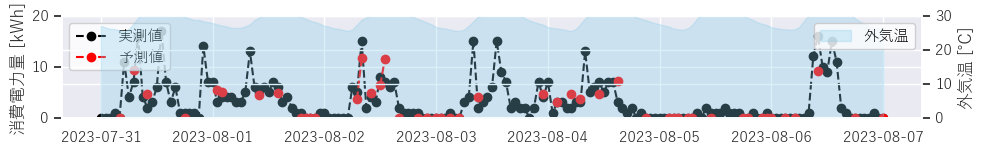

In [135]:
#時刻別予測結果
# 8月5日から8月15日までのデータをフィルタリング
start_date = '2023-07-31'
end_date = '2023-08-07'
filtered_df = main_df[(main_df.index >= start_date) & (main_df.index <= end_date)]
#display(filtered_df)

# プロット作成
fig, ax1 = plt.subplots(figsize=(10, 1.7))

# 第1軸: 実測値と予測値の線グラフ
ax1.plot(filtered_df.index, filtered_df.iloc[:, 48],color='black', marker='o',linestyle="--", label='実測値')
ax1.plot(filtered_df.index, filtered_df.iloc[:, 49], color='red', marker='o',linestyle="--", label='予測値')
#ax1.fill_between(filtered_df.index, filtered_df.iloc[:, 48], color='grey', alpha=0.3, label='実測値')
# ax1.set_xlabel('日付')
ax1.set_ylabel('消費電力量 [kWh]')
ax1.grid(True)
ax1.legend(loc='upper left')
ax1.set_ylim(0, 20)

# 第2軸: 外気温の面グラフ
ax2 = ax1.twinx()
ax2.fill_between(filtered_df.index, filtered_df.iloc[:, 1], color='skyblue', alpha=0.3, label='外気温')
ax2.set_ylabel('外気温 [℃]')
ax2.legend(loc='upper right')
ax2.set_ylim(0, 30)

# プロットの表示
plt.tight_layout()
plt.show()
#plt.savefig('scatter_plot_7.png', dpi=300, bbox_inches='tight')

In [145]:
#予測値の月別平均比較
for month in range(1, 6):
    # 月ごとのデータをフィルタリング
    month_df = main_df[(main_df.index.month == month) & (main_df.index.year == 2023)]

    # "正解"と"予測"の列を選択
    correct_values = month_df.filter(like='正解')
    predicted_values = month_df['予測']  # "予測"カラムが1つだけと仮定

    # 休日(is_holiday=1)のデータをフィルタリング
    holiday_df = month_df[month_df['is_holiday'] == 1]
    # 平日(is_holiday=0)のデータをフィルタリング
    weekday_df = month_df[month_df['is_holiday'] == 0]

    # 各日ごとのデータをプロット
    def plot_data(df, title, filename):
        correct_values = df.filter(like='正解')
        predicted_values = df['予測']
        plt.figure(figsize=(7, 2))
        days_in_month = correct_values.index.day.unique()

        # 各日ごとのデータを灰色の線でプロット
        for day in days_in_month:
            daily_data = correct_values[correct_values.index.day == day]
            plt.plot(daily_data.index.hour, daily_data.mean(axis=1), color='gray', linewidth=1)

        # "正解"の月平均をオレンジ色でプロット
        correct_hourly_mean = correct_values.groupby(correct_values.index.hour).mean()
        plt.plot(correct_hourly_mean.index, correct_hourly_mean.mean(axis=1), color='orange', linewidth=2,
                 label='実測値平均 [kWh]')

        # "予測"の月平均を青色でプロット
        predicted_hourly_mean = predicted_values.groupby(predicted_values.index.hour).mean()
        plt.plot(predicted_hourly_mean.index, predicted_hourly_mean, color='blue', linewidth=2, label='予測値平均 [kWh]')

        # グラフのラベルとタイトル
        #plt.xlabel('時刻')
        plt.ylabel('消費電力量 [kWh]')
        plt.xticks(range(0, 23, 4))
        plt.title(title)
        plt.grid(True)
        plt.ylim(0, 20)
        plt.xlim(0, 23)

        # 凡例を追加
        plt.legend(loc='upper right')

        # 図を保存
        #plt.savefig(filename, dpi=300, bbox_inches='tight')

        # プロットの表示
        plt.tight_layout()
        plt.show()

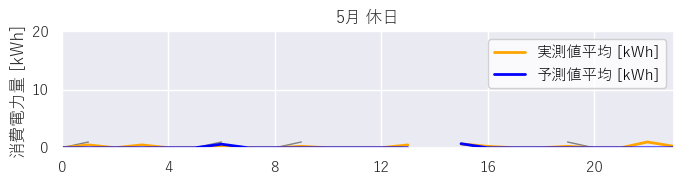

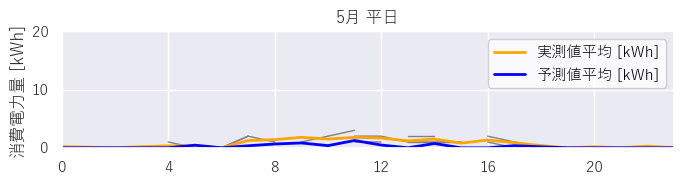

In [146]:
# 休日のデータをプロットし、保存
plot_data(holiday_df, title=f"{month}月 休日", filename=f"{month}月_休日.png")

# 平日のデータをプロットし、保存
plot_data(weekday_df, title=f"{month}月 平日", filename=f"{month}月_平日.png")

In [138]:
valid_ = prepared_data_test.copy()
display(type(datetime_data))
display(type(date_data))
valid_["datetime"]=datetime_data
valid_["date"]=str(date_data)
valid_["true"] = y_val_diff
valid_["pred"] = pred_val
display(valid_.iloc[:,-5:])

list

list

,総消費電力量,datetime,date,true,pred
0,0.0,2021-04-01 00:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.882961
22,1.0,2021-04-01 22:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",1.0,0.455404
23,0.0,2021-04-01 23:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.524787
28,1.0,2021-04-02 04:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",1.0,0.067465
31,1.0,2021-04-02 07:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",1.0,2.595360
...,...,...,...,...,...
22785,0.0,2024-03-31 10:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.255932
22787,0.0,2024-03-31 12:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.140584
22794,0.0,2024-03-31 19:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.233864
22797,0.0,2024-03-31 22:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.552745


In [38]:
graph_params = {
    1: dict(date="2023年5月", specific_season_name="May_week_1"),
    2: dict(date="2023年8月", specific_season_name="Aug_week_1"),
    3: dict(date="2023年11月", specific_season_name="Nov_week_1"),
    4: dict(date="2024年2月", specific_season_name="Feb_week_1"),
}

In [39]:
import matplotlib.patheffects as patheffects

In [139]:
def plot_mae_mape_by_month(df, feature_name,  y_limits):
    fig, ax = plt.subplots(figsize=(16, 4))
    xticks = range(1, 13)

    # Plot MAE
    plot1 = ax.plot(
        df["month"],
        df["mean_absolute_error"],
        marker="o",
        color="tab:blue",
        linestyle="--",
        label="MAE",
    )

    # Create a second y-axis for MAPE
    ax2 = ax.twinx()
    plot2 = ax2.plot(
        df["month"],
        df["mean_absolute_percentage_error"],
        marker="s",
        color="tab:orange",
        linestyle="--",
        label="MAPE",
    )

    # Format and settings
    ax.set_xticks(xticks)
    ax.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax2.grid(False)
    ax.set_title(f"{feature_name} 評価期間: 2023-04-01 ～2024-03-31 ")

    # Combine legends from both plots
    legends = plot1 + plot2
    labels = [l.get_label() for l in legends]
    ax.legend(legends, labels, loc=0)

    # Set y-axis limits
    ax.set_ylim(y_limits[0])
    ax2.set_ylim(y_limits[1])

    ax.set_xlabel("Month")
    ax.set_ylabel("MAE")
    ax2.set_ylabel("MAPE", labelpad=20, rotation=270)

    plt.show()


def plot_mae_rmse_by_month(df, feature_name, y_limits):
    fig, ax = plt.subplots(figsize=(16, 4))
    xticks = range(1, 13)

    a=[float('{:.2g}'.format(df["mean_absolute_error"][i])) for i in range(len(df))]
    df["MAE"]=a
    a=[float('{:.4g}'.format(df["root_mean_squared_error"][i]*100)) for i in range(len(df))]
    df["RMSE"]=a
    
    # Plot MAE
    plot1 = ax.plot(
        df["month"],
        df["MAE"],
        marker="o",
        color="tab:blue",
        linestyle="--",
        label="MAE",
    )
    # マーカーに件数表示
    for idx, val in enumerate(df["MAE"].tolist()):#df["mean_absolute_error"].tolist()
        ax.text(
            df["month"].tolist()[idx], df["MAE"].tolist()[idx]-0.15 , f'{val:,}', ha='center', va='bottom',
            path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")]
        )

    # Create a second y-axis for RMSE
    ax2 = ax.twinx()
    plot2 = ax2.plot(
        df["month"],
        df["RMSE"],
        marker="s",
        color="tab:orange",
        linestyle="--",
        label="RMSE",
    )

    # マーカーに件数表示
    for idx, val in enumerate(df["RMSE"].tolist()):#df["mean_absolute_error"].tolist()
        ax2.text(
            df["month"].tolist()[idx], df["RMSE"].tolist()[idx]+5 , f'{val:,}', ha='center', va='bottom',
            path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")]
        )

    # Format and settings
    ax.set_xticks(xticks)
    ax.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax2.grid(False)
    #ax.set_title(f"{feature_name} ")#評価期間: 2023-04-01 ～2024-03-31 

    # Combine legends from both plots
    legends = plot1 + plot2
    labels = [l.get_label() for l in legends]
    ax.legend(legends, labels, loc=0)

    # Set y-axis limits
    ax.set_ylim(y_limits[0])
    ax2.set_ylim(y_limits[1])
    
    ax.set_xlabel("Month")
    ax.set_ylabel("MAE[kWh]")
    ax2.set_ylabel("RMSE[%]", labelpad=20, rotation=270)

    plt.show()

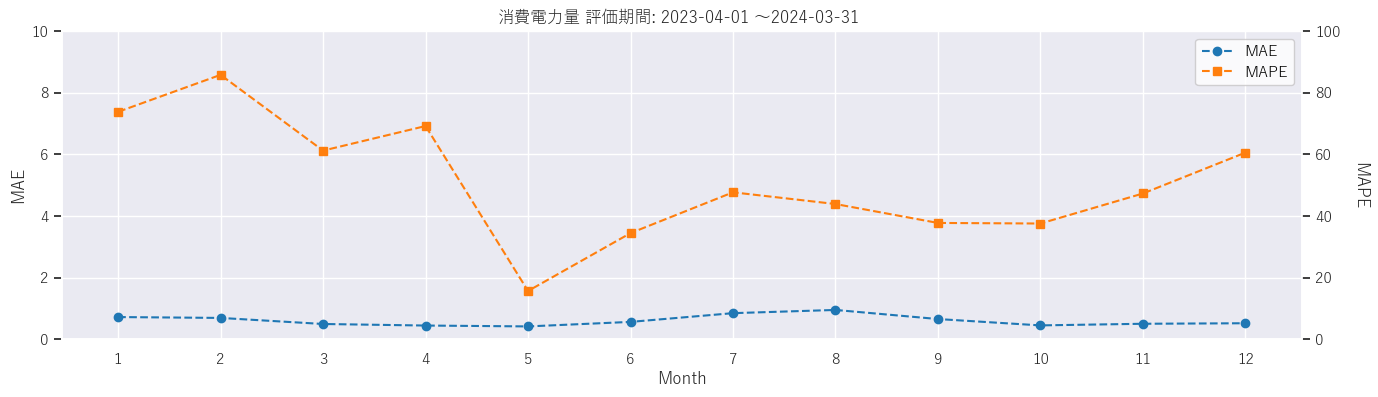

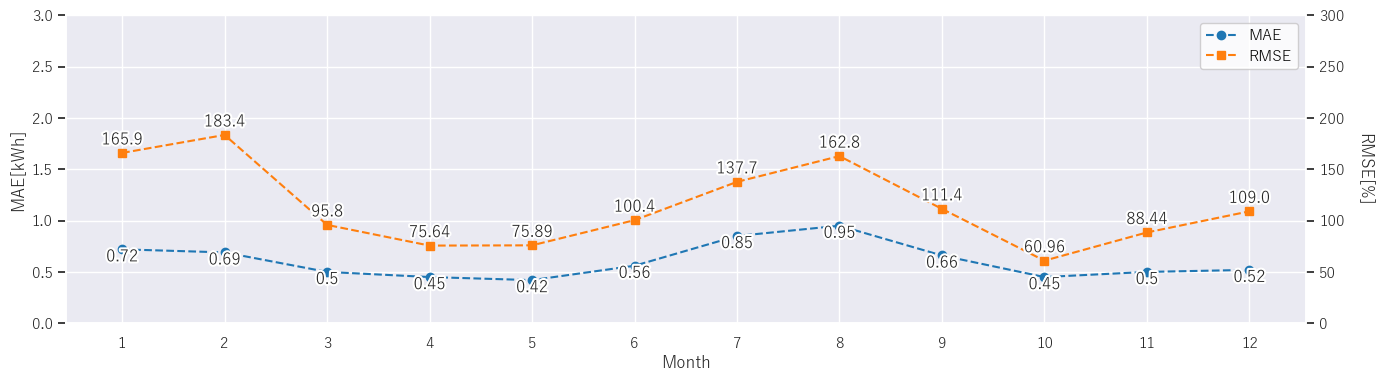

In [140]:
df_scores_month = get_scores_by_month(score_evaluator_val)
#display(df_scores_month)
# plot_scores_by_month(df_scores_month, feature_name, CASE_NAME)
plot_mae_mape_by_month(df_scores_month, feature_name,
                        [[0.0, 10.0], [0.0, 100]])
plot_mae_rmse_by_month(df_scores_month, feature_name,
                        [[0.0, 3.0], [0.0, 300.0]])

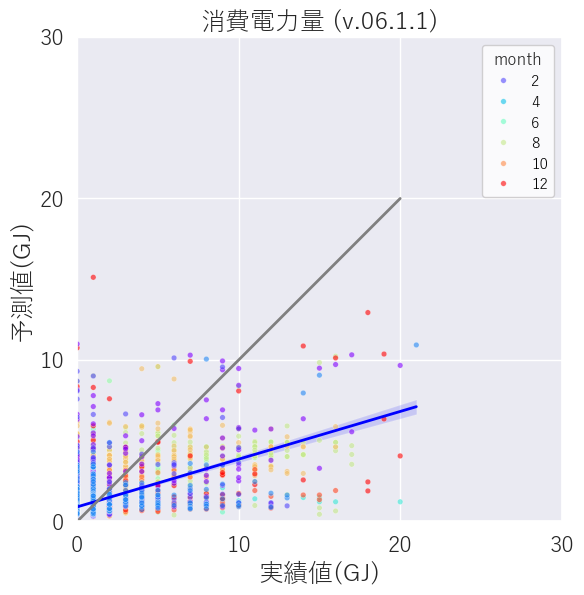

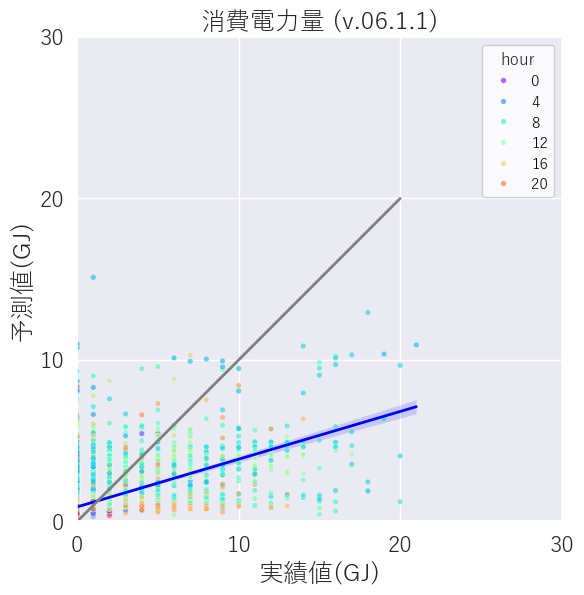

In [110]:
plot_scatter_element_with_hue(
    score_evaluator_val, ticks, hue="month", feature_name=feature_name, unit=unit, CASE_NAME=CASE_NAME
)
#plot_scatter_element_with_hue(
#    score_evaluator_val, ticks, hue="temp", feature_name=feature_name, unit=unit, CASE_NAME=CASE_NAME
#)
plot_scatter_element_with_hue(
    score_evaluator_val, ticks, hue="hour", feature_name=feature_name, unit=unit, CASE_NAME=CASE_NAME
)
#plot_scatter_element_with_hue(
#    score_evaluator_val, ticks, hue="weekday", feature_name=feature_name, unit=unit, CASE_NAME=CASE_NAME
#)
#plot_scatter_element_with_hue(
#    score_evaluator_val, ticks, hue="holiday", feature_name=feature_name, unit=unit, CASE_NAME=CASE_NAME
#)
#plot_scatter_element_with_hue(
#    score_evaluator_val, ticks, hue="holiday", feature_name=feature_name, unit=unit, CASE_NAME=CASE_NAME
#)

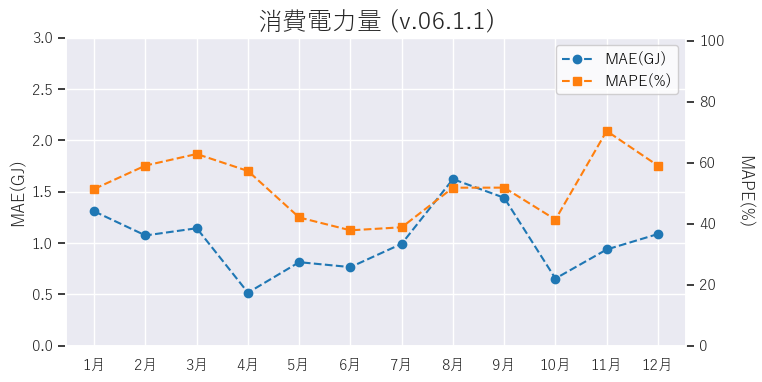

In [111]:
df = df_scores_month.copy()
fig, ax, ax2 = plot_monthly_scores(
    df, feature_name, CASE_NAME, y_limit=[3.0, 101])

ValueError: Could not interpret value `temp` for `y`. An entry with this name does not appear in `data`.

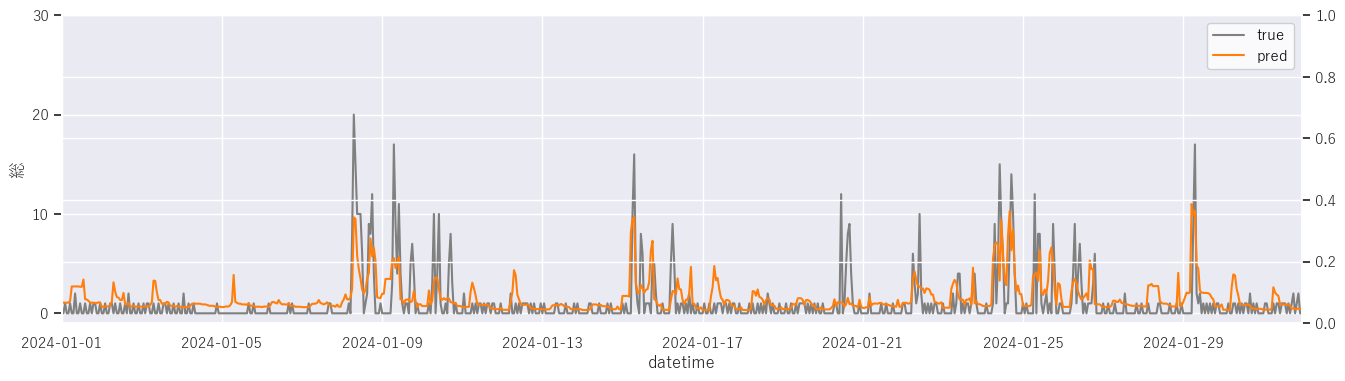

In [112]:
for month in range(1, 13):
    plot_ts_valid_with_temp(
        create_specific_month(valid_, month=month),
        output_features,
        ticks,
        title=f"{month}月 ({CASE_NAME})",
    )

In [30]:
# score_evaluator_val.df.to_excel(
#     os.path.join(result_data_path, f"{feature_name}_valid_{CASE_NAME}.xlsx")
# )